In [1]:
import sys
import pathlib
import warnings
from typing import List, Callable, Union
from itertools import product, combinations
from collections import defaultdict
from copy import copy

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from IPython.display import Image, display, Latex

import pysqkit as sq

define the image directory of the folder

In [2]:
cur_dir = pathlib.Path.cwd()
img_dir = cur_dir.parent / 'img'
if not img_dir.exists():
    warnings.warn("Failed to locate the image directory, images might fail to display.")

define some utility functions

In [3]:
def get_levels(system: Union[sq.Qubit, sq.QubitSystem], state_labels: List[str]) -> xr.DataArray:
    """Converts state labels to system indices and sorts them in ascending order"""
    if isinstance(system, sq.Qubit):
        _levels = [int(label) for label in state_labels] 
    elif isinstance(system, sq.QubitSystem):
        bare_energies = system.eig_energies(bare_system=True)
        _levels = [system.state_index(label, bare_energies=bare_energies) for label in state_labels]
    else:
        raise ValueError("Unknown system type")
    level_inds = xr.DataArray(_levels, dims=['label'], coords=dict(label=state_labels))
    return level_inds.sortby(level_inds)

def get_trans_freq(system: Union[sq.Qubit, sq.QubitSystem], levels: xr.DataArray) -> xr.DataArray:
    """Returns the transition frequencies between the given levels of the system"""
    eig_energies = system.eig_energies(levels=levels.data)
    trans_freqs = xr.DataArray(
        eig_energies[:,np.newaxis] - eig_energies, 
        dims=['out_state', 'in_state'], 
        coords=dict(out_state=levels.label.data, in_state=levels.label.data,)
    )
    return trans_freqs
    
def get_mat_elems(system: Union[sq.Qubit, sq.QubitSystem], op : Union[np.ndarray, str], levels: xr.DataArray) -> xr.DataArray:
    """Returns the matrix element of the given operator for the system and for the provided levels"""
    mat_elems = system.mat_elements(op, levels=levels.data, as_xarray=True)
    mat_elems = mat_elems.assign_coords(in_level=levels.label.data, out_level=levels.label.data)
    return mat_elems.rename(dict(in_level='in_state', out_level='out_state'))

Qubit Setup

In [4]:
transmon_params = dict(
    label='transmon', 
    max_freq = 4.5, # Target fluxonium frequency
    anharm = -0.3, # Standard transmon anharmonicity
    dim_hilbert = 5 # Just a choice, bro
)

fluxonium_params = dict(
    label='fluxonium',
    joseph_energy=5.899, # Initial value, which we'll optiimze over 
    charge_energy=0.973, # Fixing E_C to 1GHz for the purpose of this scan
    induct_energy=0.457, # Current choice, not too important for gate speed/crosstalk. s
    flux = 0.5, # Optimal point
    dim_hilbert=100 # Just a choice bro
)

coupling_str = 0.025 # We'll optimise this later.
num_flux_levels = 7 # Just a choice

In [5]:
transmon = sq.qubits.SimpleTransmon(**transmon_params) # Create the transmon since it has all parameters fixed anyhow

In [6]:
qubit_states = ['0','1', '2', '3', '4',] # Fluxonium states of interest
system_states = ['00', '01', '10', '11', '03', '13'] #Transmon-Fluxonium state of interest (for gate or crosstalk)

## Scan of interaction paramter for $E_{J}$ for resonant condition

In [7]:
joseph_energies = np.linspace(4, 10, 500)

result = defaultdict(list)
params = copy(fluxonium_params)

for joseph_energy in joseph_energies:
    params['joseph_energy'] = joseph_energy
    fluxonium  = sq.qubits.Fluxonium(**params)
    fluxonium.diagonalize_basis(num_flux_levels)
    system = transmon.couple_to(fluxonium, coupling=sq.couplers.capacitive_coupling, strength=coupling_str)
    
    qubit_levels = get_levels(fluxonium, qubit_states)
    result['flux_trans_freq'].append(get_trans_freq(fluxonium, qubit_levels))
    result['flux_mat_elems'].append(get_mat_elems(fluxonium, 'charge_op', qubit_levels))
    
    sys_levels = get_levels(system, system_states)
    result['sys_trans_freq'].append(get_trans_freq(system, sys_levels))
    
fluxonium_dataset = xr.Dataset(
    data_vars=dict(
        trans_freq = xr.concat(result['flux_trans_freq'], dim='joseph_energy'),
        mat_elems = xr.concat(result['flux_mat_elems'], dim='joseph_energy')
    )
)
fluxonium_dataset = fluxonium_dataset.assign_coords(joseph_energy=joseph_energies)

sys_trans_freq = xr.concat(result['sys_trans_freq'], dim='joseph_energy')
sys_trans_freq = sys_trans_freq.assign_coords(joseph_energy=joseph_energies)

In [8]:
crosstalk_strengths = abs(sys_trans_freq.sel(in_state='01', out_state='11') - sys_trans_freq.sel(in_state='00', out_state='10'))
int_strengths = abs(sys_trans_freq.sel(in_state='00', out_state='03') - sys_trans_freq.sel(in_state='10', out_state='13'))

int_trans_freq = fluxonium_dataset['trans_freq'].sel(in_state='3', out_state='4')
res_cond_ind = int(int_trans_freq.where(int_trans_freq >= transmon.max_freq).argmin())
opt_joseph_energy = float(fluxonium_dataset.joseph_energy[res_cond_ind])

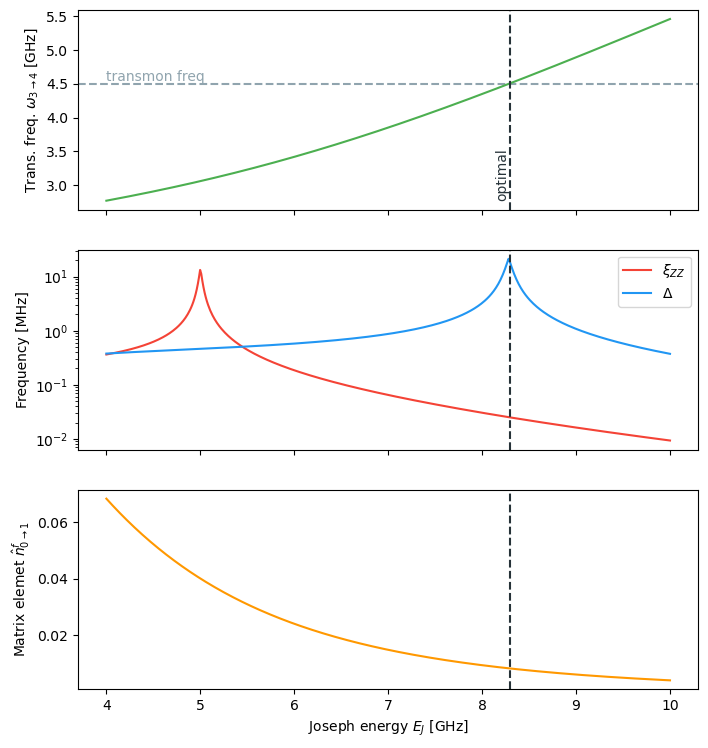

In [9]:
fig, (top_ax, mid_ax, bot_ax) = plt.subplots(3, 1, figsize=(8, 9), sharex=True, dpi=100)

top_ax.axhline(transmon.max_freq, linestyle='--', color='#90a4ae')
top_ax.text(fluxonium_dataset.joseph_energy.min(), transmon.max_freq, 'transmon freq', color='#90a4ae', ha='left', va='bottom')
top_ax.plot(fluxonium_dataset.joseph_energy, int_trans_freq, label=r'$\left|3\right\rangle \rightarrow \left|4\right\rangle$', color='#4caf50')
top_ax.axvline(opt_joseph_energy, linestyle='--', color='#263238')
top_ax.text(opt_joseph_energy, int_trans_freq.min(), r'optimal', color='#263238', ha='right', va='bottom', rotation=90)
top_ax.set_ylabel(r'Trans. freq. $\omega_{3 \rightarrow 4}$ [GHz]')

mid_ax.plot(sys_trans_freq.joseph_energy, crosstalk_strengths*1e3, color='#f44336', label=r'$\xi_{ZZ}$')
mid_ax.plot(sys_trans_freq.joseph_energy, int_strengths*1e3, color='#2196f3', label=r'$\Delta$')
mid_ax.axvline(opt_joseph_energy, linestyle='--', color='#263238')
mid_ax.set_yscale('log')
mid_ax.set_ylabel("Frequency [MHz]")
mid_ax.legend()


bot_ax.plot(fluxonium_dataset.joseph_energy, np.abs(fluxonium_dataset['mat_elems'].sel(in_state='0', out_state='1')), color='#ff9800')
bot_ax.axvline(opt_joseph_energy, linestyle='--', color='#263238')
bot_ax.set_ylabel(r'Matrix elemet $\hat{n}^{f}_{0 \rightarrow 1}$')
bot_ax.set_xlabel("Joseph energy $E_{J}$ [GHz]")

plt.show()

In [10]:
fluxonium_params['joseph_energy'] = opt_joseph_energy # We can now fix the E_{J} of the fluxonium
fluxonium = sq.qubits.Fluxonium(**fluxonium_params) # And we can create it since it no longer has paramters
fluxonium.diagonalize_basis(num_flux_levels)

# Scan over $J_c$ for optimal crosstalk and interaction strength

In [11]:
coupling_strengths = np.linspace(0.01, 0.25, 500)
result = []

for coup_str in coupling_strengths:
    system = transmon.couple_to(fluxonium, coupling=sq.couplers.capacitive_coupling, strength=coup_str)
    
    sys_levels = get_levels(system, system_states)
    result.append(get_trans_freq(system, sys_levels))

sys_trans_freq = xr.concat(result, dim='coupling_strength')
sys_trans_freq = sys_trans_freq.assign_coords(coupling_strength=coupling_strengths)

In [12]:
crosstalk_strengths = abs(sys_trans_freq.sel(in_state='01', out_state='11') - sys_trans_freq.sel(in_state='00', out_state='10'))
int_strengths = abs(sys_trans_freq.sel(in_state='00', out_state='03') - sys_trans_freq.sel(in_state='10', out_state='13'))

crosstalk_tol = 30e-6 #Corresponding to 30kHz but in GHz
crosstalk_cond_ind = int(crosstalk_strengths.where(crosstalk_strengths <= crosstalk_tol).argmax())
opt_coupling_str = float(sys_trans_freq.coupling_strength[crosstalk_cond_ind])

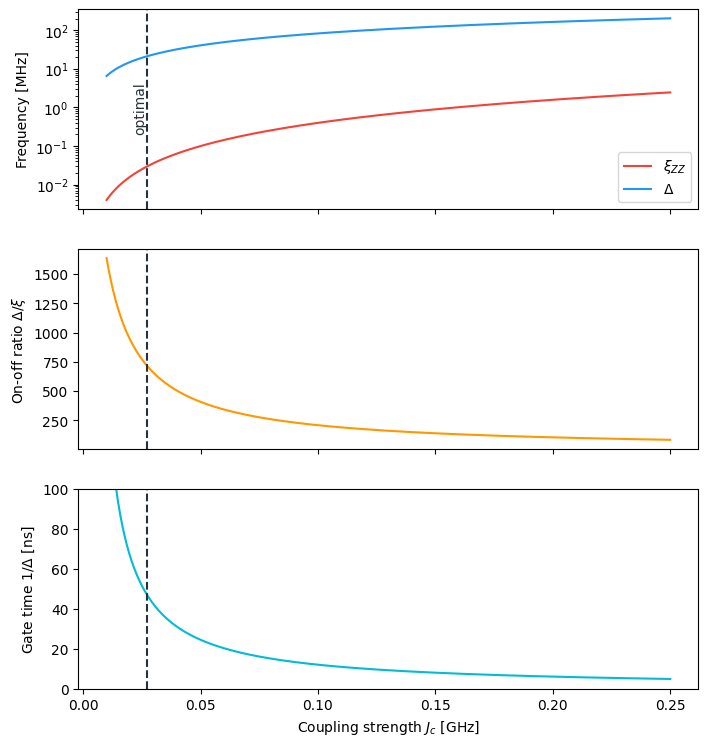

In [45]:
fig, (top_ax, mid_ax, bot_ax)  = plt.subplots(3, 1, figsize=(8, 9), sharex=True, dpi=100)

top_ax.plot(sys_trans_freq.coupling_strength, crosstalk_strengths*1e3, color='#f44336', label=r'$\xi_{ZZ}$')
top_ax.plot(sys_trans_freq.coupling_strength, int_strengths*1e3, color='#2196f3', label=r'$\Delta$')
top_ax.axvline(opt_coupling_str, linestyle='--', color='#263238')
top_ax.text(opt_coupling_str, 1, r'optimal', color='#263238', ha='right', va='center', rotation=90)
top_ax.set_yscale('log')
top_ax.set_ylabel("Frequency [MHz]")
top_ax.legend()


mid_ax.plot(sys_trans_freq.coupling_strength, int_strengths/crosstalk_strengths, color='#ff9800')
mid_ax.axvline(opt_coupling_str, linestyle='--', color='#263238')
mid_ax.set_ylabel(r'On-off ratio $\Delta / \xi$')

bot_ax.plot(sys_trans_freq.coupling_strength, 1/int_strengths, color='#00bcd4')
bot_ax.axvline(opt_coupling_str, linestyle='--', color='#263238')
bot_ax.set_ylim(0, 100)
bot_ax.set_ylabel('Gate time $1/\Delta$ [ns]')
bot_ax.set_xlabel("Coupling strength $J_{c}$ [GHz]")

plt.show()

In [37]:
system = transmon.couple_to(fluxonium, coupling=sq.couplers.capacitive_coupling, strength=opt_coupling_str) #With all parameters
sys_levels = get_levels(system, system_states)
trans_freqs = get_trans_freq(system, sys_levels)

Interaction parameters

In [38]:
crosstalk_strength = float(abs(trans_freqs.sel(in_state='01', out_state='11') - trans_freqs.sel(in_state='00', out_state='10')))
display(Latex(r'$\xi_{{ZZ}}/2 \pi$ =  {:.5f} kHz'.format(crosstalk_strength*1e6)))

int_strengths = float(abs(trans_freqs.sel(in_state='10', out_state='13') - trans_freqs.sel(in_state='00', out_state='03')))
display(Latex(r'$\Delta_{{13-04}} = $ {:.5f} MHz'.format(int_strengths*1e3)))

display(Latex(r'$1/\Delta_{{13-04}} = $ {:.5f} ns'.format(1/int_strengths)))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Qubit parameters

In [39]:
display(Latex(r'$E_{{C}} = $ {:.3f} GHz'.format(fluxonium_params['charge_energy'])))
display(Latex(r'$E_{{L}} = $ {:.3f} GHz'.format(fluxonium_params['induct_energy'])))
display(Latex(r'$E_{{J}} = $ {:.3f} GHz'.format(fluxonium_params['joseph_energy'])))
display(Latex(r'$J_{{c}} = $ {:.3f} MHz'.format(opt_coupling_str*1e3)))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>